In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import requests
from concurrent.futures import ThreadPoolExecutor
import time

In [2]:
# import the datasets...
PHI = pd.read_json("../data/large_data/PHI_v1.0.json")
iphi = pd.read_json("../data/large_data/iphi.json")

In [3]:
PHI = PHI.merge(iphi.rename(columns={"id":"PHI_ID"}), on="PHI_ID", how="outer")

In [4]:
PHI_sample = PHI.sample(1000, random_state=1)
PHI_sample.head(10)

,URL,Book,Text,hdr1,hdr2,tildeinfo,note,lines,metadata_x,data,...,text,metadata_y,region_main_id,region_main,region_sub_id,region_sub,date_str,date_min,date_max,date_circa
52461,/text/170429?location=1703&patt=&bookid=140&bo...,IGBulg V,5170,Regions\nNorthern Greece (IG X)Macedonia,IGBulg V\n5170,"Oescus & Utus Rivers, area of — Lyutibrod — SE...",,5.0,1\n\n\n\n5,ἐγὸ {²⁶ἐγὼ}²⁶ Εὐ-\nστάθιος\nἐπλήρο-\nσα {²⁶ἐπλ...,...,εγο ευσταθιος επληροσα τα εργα.,"Oescus & Utus Rivers, area of — Lyutibrod — SE...",1697.0,Thrace and the Lower Danube (IG X),1687.0,Thrace and Moesia Inferior,,NaN,NaN,NaN
7591,/text/7984?location=1700&patt=&bookid=5&offset...,IG II²,5658,Regions\nAttica (IG I-III)\nAttica,IG II²\n5658,Att. — med. s. IV a.,,14.0,1\n\n2a\ncol. I.3\n\n5\n\ncol. II.3\n\n5\ncol....,Δημαρέτη Λεωκράτους\nἈναφλυστίου θυγάτηρ.\ndua...,...,δημαρετη λεωκρατους αναφλυστιου θυγατηρ. αριστ...,Att. — med. s. IV a.,1701.0,Attica (IG I-III),1700.0,Attica,med. s. IV a.,NaN,NaN,NaN
78887,/text/208682?location=1681&patt=&bookid=352&of...,Nymphaeum,49,Regions\nCyprus ([IG XV])\nunspecified subregion,Nymphaeum\n49,Kypros — Nymphaion (Kafizin) — 225-218 BC,,3.0,1\n\n,[Νύμφηι Ἀδελφῆι]?\nΔημήτρειος Καλλικλεῦς Ταμάσ...,...,[νυμφηι αδελφηι] δημητρειος καλλικλευς ταμασιο...,Kypros — Nymphaion (Kafizin) — 225-218 BC,1680.0,Cyprus ([IG XV]),1681.0,unspecified subregion,225-218 BC,-225.0,-218.0,0.0
9436,/text/9829?location=1700&patt=&bookid=5&offset...,IG II²,7459,Regions\nAttica (IG I-III)\nAttica,IG II²\n7459,Att. — post med. s. II p.,,1.0,1,— —ὼ Ἐπαφρο[δείτο]υ ἐκ Στει[ρι]ῶν.,...,--ω επαφρο[δειτο]υ εκ στει[ρι]ων.,Att. — post med. s. II p.,1701.0,Attica (IG I-III),1700.0,Attica,post med. s. II p.,NaN,NaN,NaN
185217,/text/319315?location=1703&patt=&bookid=172&of...,SEG,8:71,Regions\nGreater Syria and the EastSyria and P...,SEG\n8:71,Pal. [Rhodes] — Skythopolis (Beth Shean) — 2nd...,,3.0,1\n\ndevice:,Ἀρισ[τοκ]λεῦς.\n\n{²rose in center}²,...,αρισ[τοκ]λευς.,Pal. [Rhodes] — Skythopolis (Beth Shean) — 2nd...,1693.0,Greater Syria and the East,1657.0,Palaestina,2nd c. BC,-200.0,-101.0,0.0
109709,/text/242840?location=1676&patt=&bookid=472&of...,"IGLSyr 3,1",760,Regions\nGreater Syria and the East\nSyria and...,"IGLSyr 3,1\n760","Syr., Antioch. — Antiochia",,1.0,1,<Μ>άλχου(?).,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208759,/text/344381?location=1665&patt=&bookid=874&of...,"IG XII,6",2:607,"Regions\nAegean Islands, incl. Crete (IG XI-[X...","IG XII,6\n2:607",Aeg. Islands — Samos Isl. — Samos (Pythagoreio...,Dedication to Hercules. Small column of gray ...,3.0,1\n\n,Herculi\nAtt(ius) Epiicius ∙ v(ir) p(erfectiss...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114632,/text/247763?location=1688&patt=&bookid=490&of...,Ephesos,56,Regions\nAsia Minor\nIonia,Ephesos\n56,IEph 1464,Honorary decree of boule and [demos of Ephe...,8.0,1\n\n\n\n5\n\n\n,ἔδοξεν τῆι βουλῆι καὶ [τῶι δήμωι· —]\nεἶπεν· ἐ...,...,εδοξεν τηι βουληι και [τωι δημωι -] ειπεν επει...,IEph 1464,1702.0,Asia Minor,1688.0,Ionia,,NaN,NaN,NaN
162912,/text/296809?location=1703&patt=&bookid=172&bo...,SEG,35:615[1],Regions\nAttica (IG I-III)Rhamnous,SEG\n35:615[1],Thessalia (Pelasgiotis) — Larisa — Kalochori —...,Dedication to Artemis Throsia. Upper part of a...,1.0,1,Ἀρτέμιδι Θροσίᾳ Εὐπάτρα Πασιμεδοντεία τελέουμα...,...,αρτεμιδι θροσια ευπατρα πασιμεδοντεια τελεουμα.,Thessalia (Pelasgiotis) — Larisa — Kalochori —...,1698.0,Central Greece (IG VII-IX),899.0,"Thessaly (IG IX,2)",early 2nd c. BC,-200.0,-151.0,0.0
61834,/text/182681?location=1463&patt=&bookid=228&of...,I.Epidamnos,575,"Regions\nNorthern Greece (IG X)\nEpeiros, Illy...",I.Epidamnos\n575,Illyria — Epidamnos-Dyrrhachion (Durrës) — und...,Stamp. Roof tile.,1.0,1,[— —]οπι[— —].,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson", driver="GeoJSON")

# Load dump of Trismegistos places

In [7]:
export_geo = pd.read_csv("../data/large_data/export_geo.csv")
export_geo.head(10)

,id,country,name_standard,begin_date,end_date,coordinates;
0,1,ghost name,A[..]....,0,0,;
1,2,Egypt,A.[ ],-228,-227,;
2,3,Egypt,A.[ ],164,164,;
3,4,Egypt,Aalabin Topos,700,725,;
4,5,Egypt,Aanemooch Topos,700,725,;
5,6,Egypt,Ab[ ] Epoikion,130,160,;
6,7,Egypt,Ab( ) Chorion,600,799,;
7,8,ghost name,Abak( ),0,0,;
8,9,Egypt,Abaktou Topos,524,725,;
9,10,Sudan,Abale,77,77,"17.682319,33.975361;"


In [8]:
len(export_geo)

60677

In [16]:
export_geo = export_geo[export_geo["coordinates;"].str.contains(",")].copy()
export_geo.head(5)

,id,country,name_standard,begin_date,end_date,coordinates;,y_lat,x_long
9,10,Sudan,Abale,77,77,"17.682319,33.975361;",17.682319,33.975361;
12,13,Egypt,Abaton,-399,499,"24.041393,32.897895;",24.041393,32.897895;
13,14,Greece,Abdera,900,999,"40.95,24.983333;",40.95,24.983333;
30,31,Egypt,Abu el-Matamir,0,0,"30.908411,30.148487;",30.908411,30.148487;
32,33,Egypt,Amouda,77,77,"22.33644375,31.62656425;",22.33644375,31.62656425;


In [20]:
export_geo["y_lat"] = export_geo["coordinates;"].apply(lambda x: float(x.partition(",")[0].replace(";","")))
export_geo["x_long"] = export_geo["coordinates;"].apply(lambda x: float(x.partition(",")[2].replace(";","")))


In [22]:
TM_geo = gpd.GeoDataFrame(export_geo, geometry=gpd.points_from_xy(export_geo["x_long"], export_geo["y_lat"]))

In [23]:
#TM_geo = gpd.read_file("../data/large_data/TM_geo.json", driver="GeoJSON")
TM_geo.head(5)

,id,country,name_standard,begin_date,end_date,coordinates;,y_lat,x_long,geometry
9,10,Sudan,Abale,77,77,"17.682319,33.975361;",17.682319,33.975361,POINT (33.97536 17.68232)
12,13,Egypt,Abaton,-399,499,"24.041393,32.897895;",24.041393,32.897895,POINT (32.89789 24.04139)
13,14,Greece,Abdera,900,999,"40.95,24.983333;",40.950000,24.983333,POINT (24.98333 40.95000)
30,31,Egypt,Abu el-Matamir,0,0,"30.908411,30.148487;",30.908411,30.148487,POINT (30.14849 30.90841)
32,33,Egypt,Amouda,77,77,"22.33644375,31.62656425;",22.336444,31.626564,POINT (31.62656 22.33644)


<AxesSubplot:>

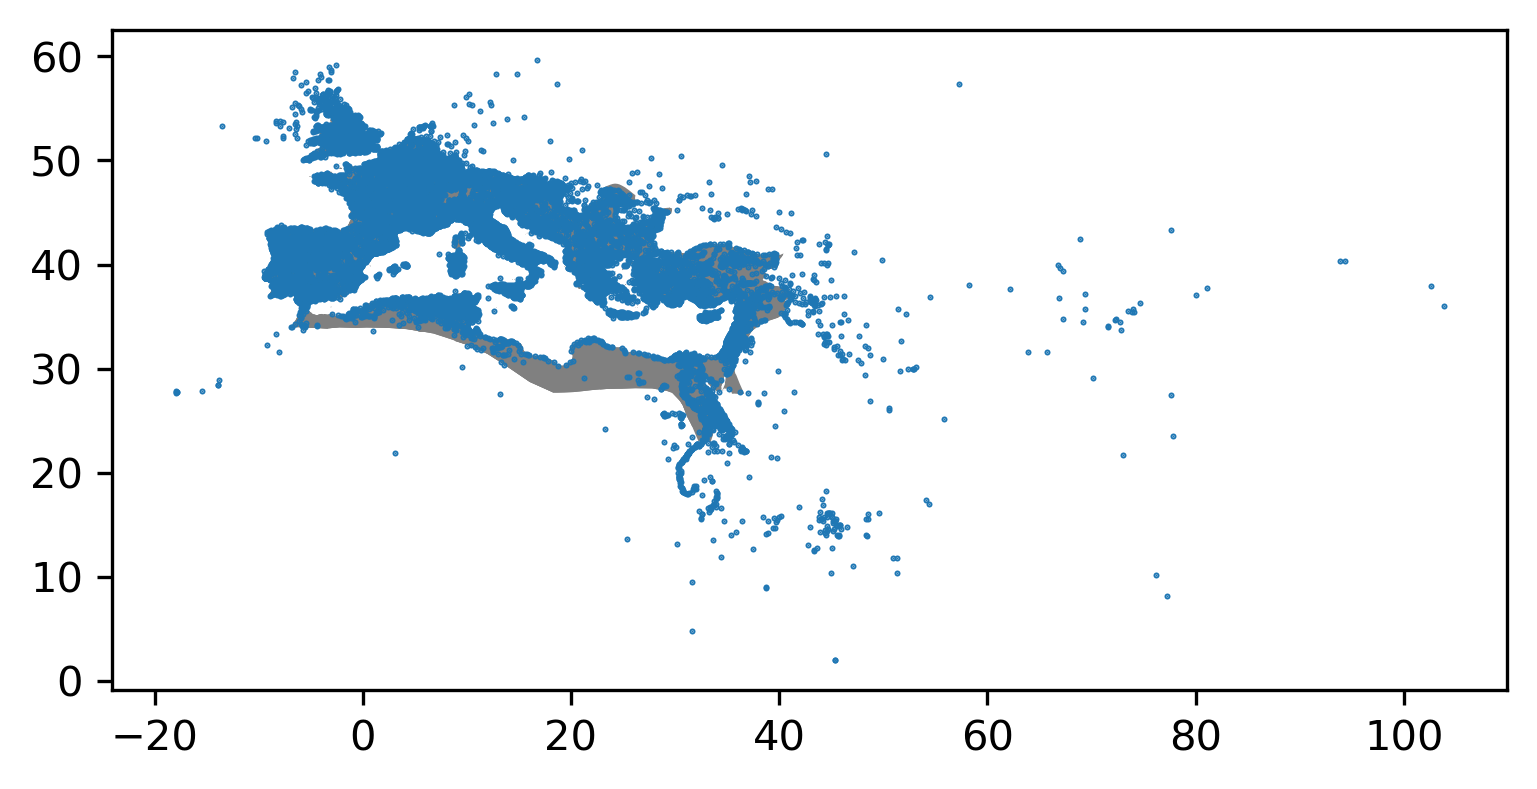

In [27]:
fig, ax = plt.subplots(dpi=300)
pleiades_regions.plot(ax=ax, color="grey")
TM_geo.plot(ax=ax, markersize=0.2)

In [31]:
# trismegistos api
base_url = "https://www.trismegistos.org/dataservices/texrelations/{0}?source=phi"

In [71]:
%%time
resps = []
for n in PHI_sample["PHI_ID"]:
    resp_json = requests.get(base_url.format(str(n))).json()
    resp_json = dict([(list(el.keys())[0], list(el.values())[0]) for el in resp_json])
    resps.append(resp_json)

CPU times: user 18.2 s, sys: 1.81 s, total: 20 s
Wall time: 3min 36s


In [72]:
PHI_sample_alts = pd.DataFrame.from_records(resps)
PHI_sample_alts.head(10)

,TM_ID,EDB,EDH,EDCS,EDR,HE,UOXF,RIB,PHI,LUPA,...,ALA,CPI,GLAUx,Papyrus_Projekt,GEM,Innovating_knowledge,PUL,4CARE/DEChriM,NYU_Amheida,WARNING
0,[762219],None,None,None,None,NaN,None,NaN,[170429],None,...,None,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None
1,[793687],None,None,None,None,NaN,None,NaN,[7984],None,...,None,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None
2,[912191],None,None,None,None,NaN,None,NaN,[208682],None,...,None,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None
3,[795529],None,None,None,None,NaN,None,NaN,[9829],None,...,None,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None
4,[876295],None,None,None,None,NaN,None,NaN,[319315],None,...,None,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None
5,[758121],None,None,None,None,NaN,None,NaN,[242840],None,...,None,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None
6,[384368],None,None,[22200745],None,NaN,None,NaN,[344381],None,...,None,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None
7,[851714],None,None,None,None,NaN,None,NaN,[247763],None,...,None,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None
8,[887429],None,None,None,None,NaN,None,NaN,[296809],None,...,None,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None
9,[927369],None,None,None,None,NaN,None,NaN,[182681],None,...,None,None,NaN,NaN,NaN,NaN,NaN,None,NaN,None


In [82]:
def get_inscription_data(phi_id):
    try:
        resp_json = requests.get(base_url.format(str(phi_id))).json()
        resp_json = dict([(list(el.keys())[0], list(el.values())[0]) for el in resp_json])
    except:
        time.sleep(1)
        try:
            resp_json = requests.get(base_url.format(str(phi_id))).json()
            resp_json = dict([(list(el.keys())[0], list(el.values())[0]) for el in resp_json])
        except:
            resp_json = {}
    return resp_json

In [83]:
PHI[10:20]["PHI_ID"]


10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
Name: PHI_ID, dtype: int64

In [87]:
%%time
### main run of the function

step=200
all_inscriptions = []
for num in range(0, len(PHI), step):
    actual_nums = PHI[num:num+step]["PHI_ID"].tolist()
    with ThreadPoolExecutor(max_workers=step*1.5) as pool:
        currently_parsed = list(pool.map(get_inscription_data,actual_nums))
    all_inscriptions.extend(currently_parsed)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "<timed exec>", line 8, in <module>
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/concurrent/futures/_base.py", line 608, in result_iterator
    yield fs.pop().result()
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/concurrent/futures/_base.py", line 440, in result
    self._condition.wait(timeout)
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/threading.py", line 312, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/magics/execution.py", line 1324, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 8, in <module>
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/concurrent/futures/_base.py", line 636, in __exit__
    self.shutdown(wait=True)
  File "/opt/homebrew/Caskroom/miniforge/base/lib/p

TypeError: object of type 'NoneType' has no len()

In [85]:
all_inscriptions

[{'TM_ID': ['786251'],
  'EDB': None,
  'EDH': None,
  'EDCS': None,
  'EDR': None,
  'HE': None,
  'UOXF': None,
  'RIB': None,
  'PHI': ['1'],
  'LUPA': None,
  'ISic': None,
  'IRT': None,
  'IGCyR': None,
  'Orient': None,
  'cisp': None,
  'DeM': None,
  'PSI': None,
  'PapNav-Duke': None,
  'Lexicological_lep': None,
  'Berliner_papyri': None,
  'Bremen_papyri': None,
  'chartes': None,
  'HispEpOl': None,
  'NaBuCCo': None,
  'Ashmolean_latin_inscriptions': None,
  'PUG': None,
  'IIP': None,
  'Dresden_papyri': None,
  'GVCYR': None,
  'Vindolanda': None,
  'Ghent_papyri': None,
  'Köln_papyri': None,
  'DDBDP': None,
  'HGV': None,
  'CACHKaRN': None,
  'PapNav-Stanford': None,
  'PapNav-Fordham': None,
  'PapNav-Berenike': None,
  'PapNav-Oslo': None,
  'PapNav-Toronto': None,
  'PapNav-Lund': None,
  'PapNav-Hermitage': None,
  'PapNav-Wisconsin': None,
  'PapNav-UTS': None,
  'PapNav-UPenn': None,
  'PSR': None,
  'PTS': None,
  'PapNav-Perkins': None,
  'PapNav-Petra': Non

In [ ]:
all_inscriptions_df = pd.DataFrame(all_inscriptions)
all_inscriptions_df.head(5)

In [ ]:
all_inscriptions_df.to_json("../data/large_data/TM_PHI.json")